## Tutoriel : interagir avec le système de stockage S3 du SSP Cloud (MinIO)

In [1]:
import os

import pandas as pd
import s3fs
import zipfile

### Récupérer les données d'un challenge

In [2]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [3]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")

['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [4]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Similarité")

['gvimont/diffusion/hackathon-minarm-2024/Similarité/.keep',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité/stanford0-car-dataset-by-classes-folder.zip']

In [5]:
# Télécharger les données dans le service
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Similarité/stanford0-car-dataset-by-classes-folder.zip'
fs.download(PATH_IN, 'data/archive.zip')

[None]

In [13]:
# Décompresser les données
with zipfile.ZipFile("data/archive.zip","r") as zip_file:
    zip_file.extractall("data/")

NB : les données peuvent être également téléchargées directement si besoin, pour être utilisées hors du SSP CLoud.
Exemple pour le fichier ci-dessus (même format de lien pour les autres challenges) : 

http://minio.lab.sspcloud.fr/gvimont/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import time
import torchvision
from torchvision import datasets, models, transforms

In [14]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, n_epochs=1):
    losses = []
    accuracies = []
    test_accuracies = []
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        model.eval()
        test_acc = eval_model(model, val_loader)
        test_accuracies.append(test_acc)

        model.train()
        scheduler.step(test_acc)
        time_elapsed = time.time() - since
        print(f"Epoch duration: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")

    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [15]:
def eval_model(model, val_loader):
    corrects = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
    acc = corrects.double() / total
    print(f'Test Acc: {acc:.4f}')
    return acc

In [161]:
if __name__ == '__main__':
    # Data transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((400,400)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'test': transforms.Compose([
            transforms.Resize((400,400)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
    }

    # Load data
    data_dir = '/home/onyxia/work/6milarit-7/data/stanford-car-dataset-by-classes-folder/car_data/car_data'
    image_datasets = {x: datasets.ImageFolder(
                        root=data_dir + '/' + x,
                        transform=data_transforms[x])
                      for x in ['train', 'test']}

    # Afficher les classes pour l'ensemble de données de formation
    train_classes = image_datasets['train'].classes
    print("Classes in train dataset:", train_classes)

    # Create data loaders
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
                   for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

    # Initialize model
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 196)

    # Use GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)

    # Train the model
    model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, scheduler,
                                                                   dataloaders['train'], dataloaders['test'], n_epochs=15)



Classes in train dataset: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012'

/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15, Loss: 4.8577, Acc: 0.0464
Test Acc: 0.1617
Epoch duration: 2m 38s
Epoch 2/15, Loss: 3.4250, Acc: 0.2225
Test Acc: 0.4650
Epoch duration: 2m 38s
Epoch 3/15, Loss: 2.3489, Acc: 0.4524
Test Acc: 0.6061
Epoch duration: 2m 43s
Epoch 4/15, Loss: 1.6563, Acc: 0.6115
Test Acc: 0.7451
Epoch duration: 2m 37s
Epoch 5/15, Loss: 1.1793, Acc: 0.7274
Test Acc: 0.7908
Epoch duration: 2m 47s
Epoch 6/15, Loss: 0.9040, Acc: 0.7839
Test Acc: 0.8227
Epoch duration: 2m 53s
Epoch 7/15, Loss: 0.5616, Acc: 0.8918
Test Acc: 0.8786
Epoch duration: 2m 53s
Epoch 8/15, Loss: 0.4778, Acc: 0.9140
Test Acc: 0.8807
Epoch duration: 2m 55s
Epoch 9/15, Loss: 0.4443, Acc: 0.9255
Test Acc: 0.8865
Epoch duration: 2m 39s
Epoch 10/15, Loss: 0.4356, Acc: 0.9242
Test Acc: 0.8865
Epoch duration: 2m 53s
Epoch 11/15, Loss: 0.4029, Acc: 0.9311
Test Acc: 0.8893
Epoch duration: 3m 5s
Epoch 12/15, Loss: 0.3868, Acc: 0.9379
Test Acc: 0.8871
Epoch duration: 3m 11s
Epoch 13/15, Loss: 0.3792, Acc: 0.9353
Test Acc: 0.8896
Epoch 

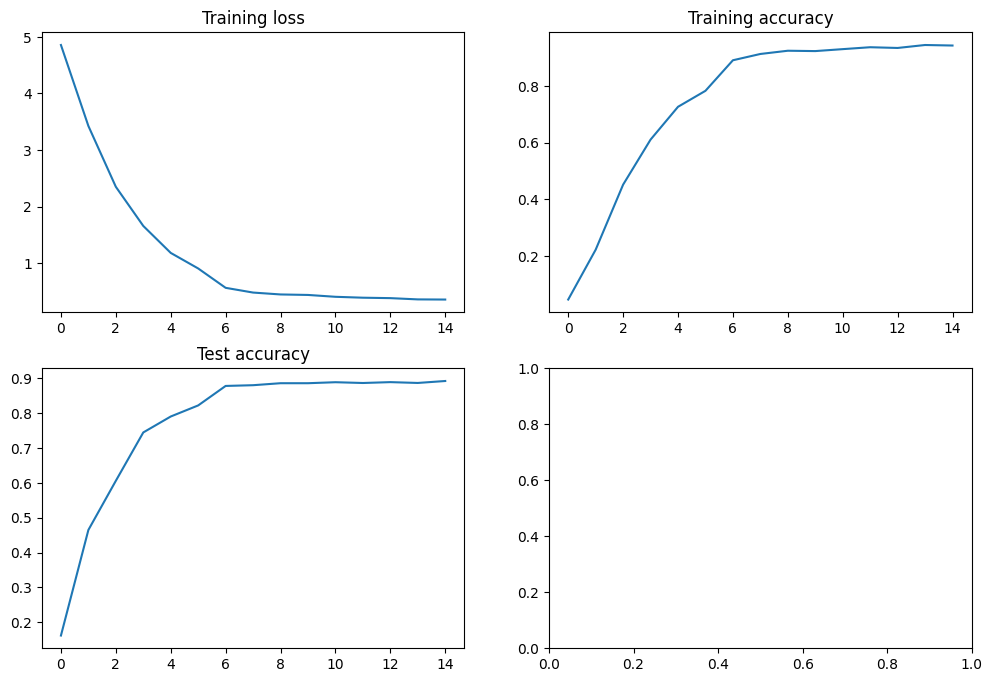

In [162]:
# Save the trained model
torch.save(model.state_dict(), "./trainedModelFinal.pt")

training_accs_np = [acc.cpu().numpy() if acc.is_cuda else acc.numpy() for acc in training_accs]
test_accs_np = [acc.cpu().numpy() if acc.is_cuda else acc.numpy() for acc in test_accs]

# Plot results
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs_np)
axarr[0, 1].set_title("Training accuracy")
axarr[1, 0].plot(test_accs_np)
axarr[1, 0].set_title("Test accuracy")

plt.show()

Analyse pour les différentes classes

In [163]:
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import random
import os
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Assuming the DataLoader for 'test' has already been created as per your dataset initialization
test_loader = DataLoader(image_datasets['test'], batch_size=4, shuffle=False)

In [170]:
def extract_brand(class_name):
    return class_name.split()[0]  # Assumant que la marque est le premier mot du nom de classe

def test_model(model, test_loader):
    model.eval()  # Make sure model is in eval mode for testing
    true_labels = []
    predictions = []
    brand_true = []
    brand_predictions = []

    with torch.no_grad():  # No need to track gradients for testing
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Collect predictions and true labels for each batch
            predictions.extend(preds.view(-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Collect brand predictions and true brand labels
            brand_predictions.extend([extract_brand(test_loader.dataset.classes[pred]) for pred in preds])
            brand_true.extend([extract_brand(test_loader.dataset.classes[label]) for label in labels])

    # Print classification report for specific models
    print("Classification report for specific models:")
    print(classification_report(true_labels, predictions, target_names=test_loader.dataset.classes))

    # Get classification report for brands
    brand_labels = [extract_brand(name) for name in test_loader.dataset.classes]
    unique_brands = sorted(set(brand_labels))  # Get unique brand names for labels in report
    print("Classification report for brands:")
    print(classification_report(brand_true, brand_predictions, labels=unique_brands, target_names=unique_brands))

    # Return confusion matrices for both models and brands
    model_conf_matrix = confusion_matrix(true_labels, predictions)
    brand_conf_matrix = confusion_matrix(brand_true, brand_predictions, labels=unique_brands)

    return model_conf_matrix, brand_conf_matrix

# Run the test function
conf_matrix, conf_matrix_brands = test_model(model, test_loader)

print(conf_matrix.head())
print(conf_matrix_brands.head())


KeyboardInterrupt: 

Visualisation

In [165]:
def load_image_from_folder(folder_path, class_name):
    class_folder = os.path.join(folder_path, class_name)
    image_files = os.listdir(class_folder)
    random_image_file = random.choice(image_files)  # Choisir une image aléatoire
    image_path = os.path.join(class_folder, random_image_file)
    print(image_path)
    image = Image.open(image_path)
    return image


def get_class_index(class_name, class_list):
    try:
        return class_list.index(class_name)
    except ValueError:
        print(f"Class '{class_name}' not found in the dataset.")
        return None

In [166]:
class GradCam:
    def __init__(self, model):
        self.model = model
        self.feature_maps = None
        self.gradients = None
        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.feature_maps = output.detach()

        def backward_hook(module, input, output):
            self.gradients = output[0].detach()

        # Assume we are using ResNet-18
        target_layer = self.model.layer4[-1]  # last layer of group 4
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class, class_names):
        self.model.zero_grad()
        output = self.model(input_image)
        class_loss = output[:, target_class]
        class_loss.backward()

        # Obtenir la prédiction de la classe par le modèle
        _, predicted_class_idx = output.max(1)  # Retourne les valeurs maximales et leurs indices

        # Vérification de l'exactitude de la prédiction
        is_correct = (predicted_class_idx.item() == target_class)

        # Obtenir le nom de la classe prédite
        predicted_class_name = class_names[predicted_class_idx.item()]

        # Redimensionnement et moyenne des gradients
        gradient = self.gradients
        pooled_gradients = torch.mean(gradient, dim=[0, 2, 3])

        # Redimensionnement pour correspondre aux cartes de caractéristiques
        for i in range(pooled_gradients.size(0)):
            self.feature_maps[0, i, :, :] *= pooled_gradients[i]

        cam = torch.sum(self.feature_maps, dim=1).squeeze().clamp(min=0)
        cam = torch.nn.functional.interpolate(cam.unsqueeze(0).unsqueeze(0), input_image.shape[2:], mode='bilinear', align_corners=False).squeeze()

        return cam, is_correct, predicted_class_name

In [167]:
# Initialisez le même modèle que celui que vous avez entraîné
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)  # Assurez-vous que cela correspond à votre configuration originale

# Chargez les poids sauvegardés
model.load_state_dict(torch.load("./trainedModelFinal.pt"))
model.eval()

# Assurez-vous de déplacer le modèle sur le bon appareil (GPU ou CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


data/stanford-car-dataset-by-classes-folder/car_data/car_data/test/BMW 1 Series Convertible 2012/05219.jpg
Valid:True
Predicted Class:BMW 1 Series Convertible 2012


/opt/mamba/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


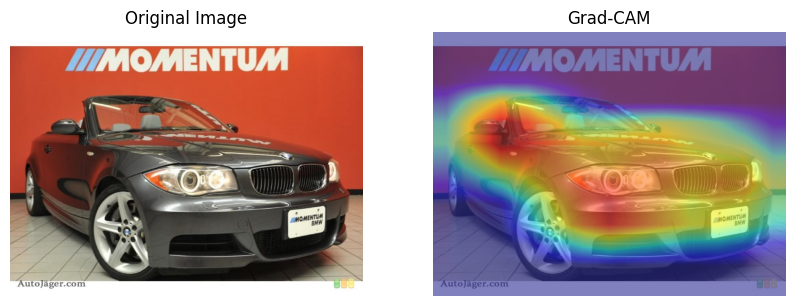

In [168]:
# Charger une image et la transformer
transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Chemin vers le dossier contenant les données de test
data_folder = 'data/stanford-car-dataset-by-classes-folder/car_data/car_data/test/'

# Choisir une classe spécifique
class_name = 'BMW 1 Series Convertible 2012'  # Assurez-vous que ce dossier existe

# Charger l'image
img = load_image_from_folder(data_folder, class_name)

# Appliquer les transformations et préparer pour le modèle
input_image = transform(img).unsqueeze(0).to(device)

# Code GradCam ici comme mentionné précédemment
grad_cam = GradCam(model)

# Générer CAM pour une classe spécifique
target_class_index = get_class_index(class_name, train_classes)  # L'index de la classe pour laquelle vous souhaitez voir la carte d'activation
cam, loss, predicted_class = grad_cam.generate_cam(input_image, target_class=target_class_index, class_names=test_loader.dataset.classes)
cam_image = cam.cpu().numpy()  # Assurez-vous que cela fonctionne avec vos dimensions d'image

print("Valid:" + str(loss))
print("Predicted Class:" + predicted_class)


# Visualiser la carte d'activation

# Redimensionner la carte de chaleur pour qu'elle corresponde aux dimensions de l'image originale
cam_image_resized = torch.from_numpy(cam_image).unsqueeze(0).unsqueeze(0)  # Ajouter les dimensions de batch et de canal
cam_image_resized = torch.nn.functional.interpolate(cam_image_resized, size=img.size[::-1], mode='bilinear', align_corners=False)
cam_image_resized = cam_image_resized.squeeze().numpy()  # Enlever les dimensions ajoutées

# Affichage
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img, alpha=0.8)  # Mettre l'image originale en arrière-plan
plt.imshow(cam_image_resized, cmap='jet', alpha=0.5)  # Superposition de la carte de chaleur
plt.title("Grad-CAM")
plt.axis('off')
plt.show()